# 2019 DSAI Midterm Project
**Kaggle Competition:** [Predict Future Sales](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview)

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor, XGBClassifier
from xgboost import plot_importance
import lightgbm as lgb

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)

# Data Description
* **sales_train.csv** - the training set. Daily historical data from January 2013 to October 2015.
* **test.csv** - the test set. You need to forecast the sales for these shops and products for November 2015.
* **items.csv** - supplemental information about the items/products.
* **item_categories.csv**  - supplemental information about the items categories.
* **shops.csv**- supplemental information about the shops.

# Data fields
* **ID** - an Id that represents a (Shop, Item) tuple within the test set
* **shop_id** - unique identifier of a shop
* **item_id** - unique identifier of a product
* **item_category_id** - unique identifier of item category
* **item_cnt_day** - number of products sold. You are predicting a monthly amount of this measure
* **item_price** - current price of an item
* **date** - date in format dd/mm/yyyy
* **date_block_num** - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* **item_name** - name of item
* **shop_name** - name of shop
* **item_category_name** - name of item category

In [2]:
items = pd.read_csv('./input/items.csv')
shops = pd.read_csv('./input/shops.csv')
cats = pd.read_csv('./input/item_categories.csv')
train = pd.read_csv('./input/sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('./input/test.csv').set_index('ID')

# Data Exploration

The time series data with seasonality.

In [46]:
sales_by_item_id = train.pivot_table(index=['item_id'],values=['item_cnt_day'],
                                        columns='date_block_num', aggfunc=np.sum, fill_value=0).reset_index()
sales_by_item_id.columns = sales_by_item_id.columns.droplevel().map(str)
sales_by_item_id = sales_by_item_id.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_item_id.columns.values[0] = 'item_id'

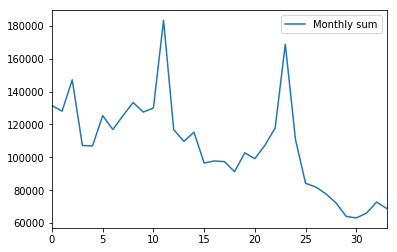

In [47]:
sales_by_item_id.sum()[1:].plot(legend=True, label="Monthly sum")

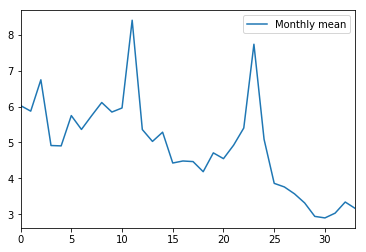

In [48]:
sales_by_item_id.mean()[1:].plot(legend=True, label="Monthly mean")

### Outdated Items (no sales for the last 6 months.)
12391 of 21807 is a huge number. Probably we can set 0 for all that items and do not make any model prediction.

In [50]:
outdated_items = sales_by_item_id[sales_by_item_id.loc[:,'27':].sum(axis=1)==0].item_id
print(outdated_items.head())
len(outdated_items)

0    0
1    1
2    2
3    3
4    4
Name: item_id, dtype: int64


12390

In [51]:
del sales_by_item_id
gc.collect()

7

### Outdated Shops
We can see new shops - probably there will be a sales spike (opening event for example). Apparently closed shops (outdated shops) - no sales for last 6 months

In [52]:
sales_by_shop_id = train.pivot_table(index=['shop_id'],values=['item_cnt_day'], 
                                        columns='date_block_num', aggfunc=np.sum, fill_value=0).reset_index()
sales_by_shop_id.columns = sales_by_shop_id.columns.droplevel().map(str)
sales_by_shop_id = sales_by_shop_id.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_shop_id.columns.values[0] = 'shop_id'

In [53]:
for i in range(6,34):
    print('Not exists in month',i,sales_by_shop_id['shop_id'][sales_by_shop_id.loc[:,'0':str(i)].sum(axis=1)==0].unique())

for i in range(6,28):
    print('Shop is outdated for month',i,sales_by_shop_id['shop_id'][sales_by_shop_id.loc[:,str(i):].sum(axis=1)==0].unique())

Not exists in month 6 [ 9 20 33 34 36 39 40 48 49]
Not exists in month 7 [ 9 20 33 34 36 39 40 48 49]
Not exists in month 8 [ 9 20 33 34 36 39 40 48 49]
Not exists in month 9 [20 33 34 36 39 40 48 49]
Not exists in month 10 [20 33 34 36 39 40 48 49]
Not exists in month 11 [20 33 34 36 39 40 48]
Not exists in month 12 [20 33 34 36 39 40 48]
Not exists in month 13 [20 33 34 36 39 40 48]
Not exists in month 14 [20 33 34 36 48]
Not exists in month 15 [20 33 34 36]
Not exists in month 16 [20 33 34 36]
Not exists in month 17 [20 33 34 36]
Not exists in month 18 [20 33 36]
Not exists in month 19 [20 36]
Not exists in month 20 [20 36]
Not exists in month 21 [36]
Not exists in month 22 [36]
Not exists in month 23 [36]
Not exists in month 24 [36]
Not exists in month 25 [36]
Not exists in month 26 [36]
Not exists in month 27 [36]
Not exists in month 28 [36]
Not exists in month 29 [36]
Not exists in month 30 [36]
Not exists in month 31 [36]
Not exists in month 32 [36]
Not exists in month 33 []
Sho

In [ ]:
# newopen_shops = sales_by_shop_id['shop_id'][sales_by_shop_id.loc[:,'0':str(i)].sum(axis=1)==0]

In [54]:
outdated_shops = sales_by_shop_id['shop_id'][sales_by_shop_id.loc[:,'27':].sum(axis=1)==0]
outdated_shops

6      8
10    13
14    17
20    23
27    30
29    32
37    40
40    43
Name: shop_id, dtype: int64

In [55]:
del sales_by_shop_id
gc.collect()

65

# Preprocessing

### Fix and Remove Outliers

There are items with strange prices and sales. Here I remove items with price > 100000 and sales > 1001.

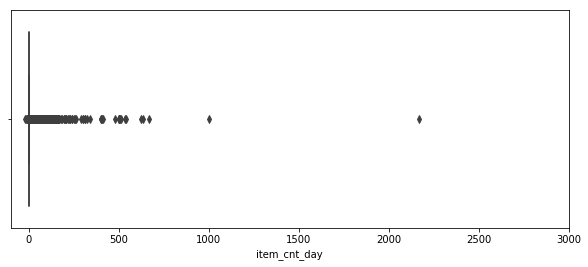

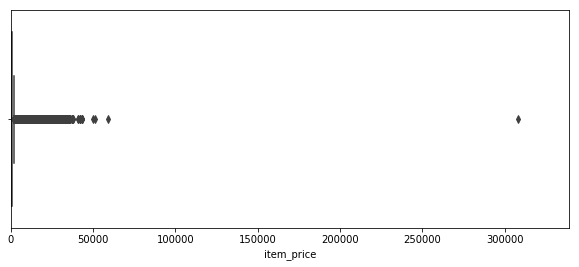

In [3]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [4]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

There is one item with price below zero. Fill it with median.

In [5]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

With a close look we can find out that some shops have duplicated id/name - probably it changed location (within commercial center), or it has a different type (isle sale point), but I decided to merge it.

In [6]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

### Shops
Observations:
* Each shop_name starts with the city name.
* Each category contains type and subtype in its name.

In [7]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [9]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]
shops.head()

,shop_id,city_code
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


### Categories
Split item_category_name into type code and subtyoe code.

In [8]:
cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [10]:
cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]
cats.head()

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13


### Items
Each item_name can be represented by item_id, so I drop the item_name column.

In [11]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [12]:
items.drop(['item_name'], axis=1, inplace=True)
items.head()

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


### Monthly Sales
The test set is a product of some shops and some items within 34 months. There are 5100 items * 42 shops = 214200 pairs. 363 items are new compared to the train. Hence, for most of the items in the test set target value should be zero. 
In the other hand, train set contains only pairs which were sold or returned in the past. The main idea is to calculate monthly sales and **extend it with zero sales** for each unique pair within the month. This way train data will be similar to test data.

In [11]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)

(363, 5100, 214200)

In [13]:
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

14.230997562408447

Aggregate train set by shop/item pairs to calculate target aggreagates, then **clip(0,20)** target value. This way train target will be similar to the test predictions.

In [14]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [15]:
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))

6.308877229690552

# Test Set
Append test set to the matrix.

In [16]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [17]:
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month

0.1077117919921875

# Create Features

It's now finish data preprocessing part, the matrix is showed below. We can start creating some features.

In [18]:
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

5.772563695907593

In [20]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code
0,0,2,19,0.0,0,40,11,4
1,0,2,27,1.0,0,19,5,10
2,0,2,28,0.0,0,30,8,55
3,0,2,29,0.0,0,23,5,16
4,0,2,32,0.0,0,40,11,4


### Lag Features
For training time series data, we need to add lag features.

In [21]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [22]:
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')

### Mean Encoded Features

Average items sold in each month.

In [24]:
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)

Average amount of sales of each items in each month. (lags = 1,2,3,6,12)

In [25]:
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

Average items sold by each shop in each month. (lags = 1,2,3,6,12)

In [26]:
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

Average items of each item category are sold in each month.

In [27]:
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

Average items of each category sold by each shop in each month.

In [28]:
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

Average items of each type_code sold by each shop in each month.

In [29]:
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

Average items of each subtype_code sold by each shop in each month.

In [31]:
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

Average itmes sold in each city in each month.

In [32]:
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

Average amount of items of each item sold in each city in each month.

In [33]:
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

Average items of each type sold in each month.

In [34]:
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

Average items of each subtype sold in each month.

In [35]:
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)

### Trend Features
Price trend for the last 6 months.

In [36]:
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

446.95911145210266

Last month shop revenue trend.

In [37]:
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

### Special features

Months: for seasonality.

In [38]:
matrix['month'] = matrix['date_block_num'] % 12

Numberof days in a month.

In [39]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

Months since the last sale for each shop/item pair and for item only.

In [40]:
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num

In [41]:
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num     

851.2992396354675

In [42]:
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')

## Final preparations

Drop the first 12 month (becausing we are using lags of 12).

In [43]:
ts = time.time()
matrix = matrix[matrix.date_block_num > 11]

Fill up null values.

In [44]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)

Add outdated_item and outdated_shop features.

In [56]:
matrix['outdated_item'] = matrix['item_id'].apply(lambda x: 0 if x in outdated_items else 1).astype('int8')
matrix['outdated_shop'] = matrix['shop_id'].apply(lambda x: 0 if x in outdated_shops else 1).astype('int8')

In [57]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 4488710 to 11128003
Data columns (total 42 columns):
date_block_num                          int8
shop_id                                 int8
item_id                                 int16
item_cnt_month                          float16
city_code                               int8
item_category_id                        int8
type_code                               int8
subtype_code                            int8
item_cnt_month_lag_1                    float16
item_cnt_month_lag_2                    float16
item_cnt_month_lag_3                    float16
item_cnt_month_lag_6                    float16
item_cnt_month_lag_12                   float16
date_avg_item_cnt_lag_1                 float16
date_item_avg_item_cnt_lag_1            float16
date_item_avg_item_cnt_lag_2            float16
date_item_avg_item_cnt_lag_3            float16
date_item_avg_item_cnt_lag_6            float16
date_item_avg_item_cnt_lag_12       

In [42]:
matrix.to_pickle('./input/data.pkl')
del matrix
del cache
del group
del items
del shops
del cats
del train
del outdated_items
del outdated_shops
gc.collect();

# 2. Modeling

In [2]:
data = pd.read_pickle('./input/data.pkl')

In [3]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
    'outdated_item',
    'outdated_shop'
]]

Validation strategy is 34 month for the test set, 33 month for the validation set and 13-33 months for the train.

In [4]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [5]:
del data
gc.collect()

29

### LightGBM

In [6]:
train_data=lgb.Dataset(X_train,label=Y_train)
valid_data=lgb.Dataset(X_valid,label=Y_valid)


params = {'boosting_type': 'gbdt',
          'max_depth' : 10,
          'objective': 'regression',
          'nthread': 5,
          'num_leaves': 32,
          'learning_rate': 0.005,
          'subsample': 0.8,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'min_split_gain': 0.5,
          'min_child_weight': 400,
          'min_child_samples': 1,
          'metric' : 'rmse'
          }

lgbm = lgb.train(params,
                 train_data,
                 25000,
                 valid_sets=[train_data, valid_data],
                 early_stopping_rounds= 25,
                 verbose_eval= 20
                 )

Training until validation scores don't improve for 25 rounds.
[20]	training's rmse: 1.14231	valid_1's rmse: 1.10175
[40]	training's rmse: 1.10252	valid_1's rmse: 1.07255
[60]	training's rmse: 1.06829	valid_1's rmse: 1.04767
[80]	training's rmse: 1.03891	valid_1's rmse: 1.02672
[100]	training's rmse: 1.01357	valid_1's rmse: 1.00898
[120]	training's rmse: 0.991729	valid_1's rmse: 0.994243
[140]	training's rmse: 0.972985	valid_1's rmse: 0.981973
[160]	training's rmse: 0.956967	valid_1's rmse: 0.971913
[180]	training's rmse: 0.943045	valid_1's rmse: 0.963671
[200]	training's rmse: 0.931022	valid_1's rmse: 0.956451
[220]	training's rmse: 0.920634	valid_1's rmse: 0.95048
[240]	training's rmse: 0.911644	valid_1's rmse: 0.945476
[260]	training's rmse: 0.903847	valid_1's rmse: 0.941302
[280]	training's rmse: 0.897007	valid_1's rmse: 0.93768
[300]	training's rmse: 0.890996	valid_1's rmse: 0.934509
[320]	training's rmse: 0.885802	valid_1's rmse: 0.931819
[340]	training's rmse: 0.881067	valid_1's 

### XGboost

In [7]:
ts = time.time()

xgb = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

xgb.fit(
    X_train, 
    Y_train,
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

In [15]:
# predictions from two models
Y_pred_xgb = xgb.predict(X_valid).clip(0, 20)
Y_test_xgb = xgb.predict(X_test).clip(0, 20)
Y_pred_lgb = lgbm.predict(X_valid).clip(0, 20)
Y_test_lgb = lgbm.predict(X_test).clip(0, 20)

# save predictions for an ensemble
pickle.dump(Y_pred_xgb, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test_xgb, open('xgb_test.pickle', 'wb'))
pickle.dump(Y_pred_lgb, open('lgb_train.pickle', 'wb'))
pickle.dump(Y_test_lgb, open('lgb_test.pickle', 'wb'))

# Mdel Ensembling
Use predictions of validation and testing data from LightGBM and XGboost models to predict the final submission.

In [16]:
xgb_train = pd.read_pickle('./input/xgb_train.pickle')
lgb_train = pd.read_pickle('./input/lgb_train.pickle')
xgb_test = pd.read_pickle('./input/xgb_test.pickle')
lgb_test = pd.read_pickle('./input/lgb_test.pickle')

In [17]:
pred_train = pd.DataFrame({
    'xgb': xgb_train,
    'lgb': lgb_train
})
pred_train.head()

,xgb,lgb
0,0.042019,0.036783
1,0.136389,0.084036
2,0.189071,0.182332
3,0.285202,0.258455
4,0.019261,0.022962


In [18]:
pred_test = pd.DataFrame({
    'xgb': xgb_test,
    'lgb': lgb_test
})
pred_test.head()

,xgb,lgb
0,0.580359,0.609284
1,0.358934,0.443720
2,1.199845,1.137932
3,0.469782,0.460154
4,3.862634,2.717435


In [32]:
gbm = XGBRegressor(
#      learning_rate = 0.02,
     n_estimators= 2000,
     max_depth= 4,
     min_child_weight= 2,
#      gamma=1,
     gamma=0.9,         
     subsample=0.8,
     colsample_bytree=0.8,
     nthread= -1,
     scale_pos_weight=1,
     verbose=True)

gbm.fit(
    pred_train,
    Y_valid,
    eval_metric="rmse",
    verbose=True)

predictions = gbm.predict(pred_test)

In [33]:
print(predictions[:100])

[0.6619231  0.2987076  1.1160108  0.47155964 3.0272124  0.6218416
 0.94163215 0.16771328 0.8830859  0.82923186 6.551222   0.16954851
 0.12797782 0.37711382 1.2939663  0.8147141  0.03372779 0.15297434
 1.424442   0.2290917  0.3836782  0.35256425 2.6573634  0.61323357
 1.4420898  0.90276015 0.29871553 0.28046355 1.1010561  2.1831117
 0.7012935  0.36796778 0.61720246 1.0251703  0.07096264 0.07096264
 0.07096264 0.75819653 0.23105869 0.1454201  0.60060287 1.2363825
 3.778568   5.482103   1.0113627  0.38092005 1.0690417  0.83087516
 0.5783709  0.80065024 0.8615769  0.6986748  0.40679377 0.4286042
 2.2435381  2.0747762  1.3225533  1.6657157  4.6732583  2.6131384
 1.1073682  0.3301919  0.22060809 0.4258554  1.1242461  0.5675286
 0.49487013 0.05857378 0.4918858  0.06810114 0.5675286  2.2663784
 0.325953   1.0869095  2.7126575  3.8647983  0.3153361  0.96589017
 0.6331567  0.7727097  1.1123843  1.6685407  0.5256429  0.23012385
 0.7336027  0.9074607  0.51740414 0.05764291 1.7162888  1.2018433
 0.

In [ ]:
submission = pd.DataFrame({
    "ID": test.index,
#     "item_id": test.item_id,
    "item_cnt_month": predictions
})
# submission['is_outdated'] = submission['item_id'].apply(lambda x: 0 if x in outdated_items else 1)
# submission['item_cnt_month'] = submission['item_cnt_month'] * submission['is_outdated']
# submission = submission.drop(['item_id', 'is_outdated'], axis=1)
submission.to_csv('submission.csv', index=False)